In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import os


In [ ]:
import matplotlib.pyplot as plt

# MNist

## Linear

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 64
nz = 48
ngf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc21 = nn.Linear(nz, nz)
        self.fc22 = nn.Linear(nz, nz)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, input):
        mu = self.fc21(input)
        logvar = self.fc22(input)
        z = self.reparameterize(mu, logvar)
        result = self.main(z.unsqueeze(-1).unsqueeze(-1))
        return result, mu, logvar
    
    def sample(self, batch_size):
        z = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(z)


In [ ]:
class LinearGenerator(nn.Module):
    def __init__(self):
        super(LinearGenerator, self).__init__()
        self.fc21 = nn.Linear(nz, nz)
        self.fc22 = nn.Linear(nz, nz)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, input):
        mu = self.fc21(input)
        logvar = self.fc22(input)
        z = self.reparameterize(mu, logvar)
        return self.main(z.unsqueeze(-1).unsqueeze(-1)), mu, logvar
    
    def sample(self, batch_size):
        z = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(z)


In [ ]:
def vae_loss(p, x, mu, logvar, weight=0.0):
    BCE = torch.nn.functional.binary_cross_entropy(p.view(-1, 32 * 32 * nc), x.view(-1, 32 * 32 * nc), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

    return BCE + (KLD * weight), BCE, KLD

In [ ]:
dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
#train_iterator = iter(cycle(train_loader))

F = Generator().to(device)
L = LinearGenerator().to(device)

optim = torch.optim.Adam(lr=lr, params=F.parameters())
optim_l = torch.optim.Adam(lr=lr, params=L.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

> Number of parameters 268033


## Variational GON

In [ ]:
#35m49s
loss_log = []
for epoch in range(50):
    epoch_loss = 0.0
    # anneal KLD from 0 to 1 over 100 epochs
    #kld_weight = min(epoch / 99.0, 1.0)
    for x, _ in train_loader:
        x = x.to(device)

        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        z = torch.zeros(batch_size, nz).to(device).requires_grad_()
        g, mu, logvar = F(z)
        inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
        z = (-grad)

        # now with z as our new latent points, optimise the data fitting loss
        g, mu, logvar = F(z)
        outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        optim.zero_grad()
        outer_loss.backward()
        optim.step()

        epoch_loss += outer_loss.item()
    
    loss_log.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch}  Loss: {epoch_loss/len(train_loader):.3f}")

    # plot reconstructions
    torchvision.utils.save_image(g, f'imgs/recon_{epoch}.png', 
        nrow=int(np.sqrt(batch_size)), padding=0)
    
    # plot samples
    torchvision.utils.save_image(F.sample(batch_size), f'imgs/sample_{epoch}.png', 
        nrow=int(np.sqrt(batch_size)), padding=0)
  

Epoch: 0  Loss: 236.417
Epoch: 1  Loss: 215.391
Epoch: 2  Loss: 204.929
Epoch: 3  Loss: 197.997
Epoch: 4  Loss: 193.331
Epoch: 5  Loss: 188.832
Epoch: 6  Loss: 185.239
Epoch: 7  Loss: 182.039
Epoch: 8  Loss: 178.917
Epoch: 9  Loss: 176.607
Epoch: 10  Loss: 174.741
Epoch: 11  Loss: 173.280
Epoch: 12  Loss: 171.864
Epoch: 13  Loss: 170.849
Epoch: 14  Loss: 169.639
Epoch: 15  Loss: 168.496
Epoch: 16  Loss: 167.510
Epoch: 17  Loss: 166.687
Epoch: 18  Loss: 166.043
Epoch: 19  Loss: 165.359
Epoch: 20  Loss: 164.809
Epoch: 21  Loss: 164.206
Epoch: 22  Loss: 163.743
Epoch: 23  Loss: 163.203
Epoch: 24  Loss: 162.836
Epoch: 25  Loss: 162.372
Epoch: 26  Loss: 162.053
Epoch: 27  Loss: 161.682
Epoch: 28  Loss: 161.392
Epoch: 29  Loss: 161.045
Epoch: 30  Loss: 160.817
Epoch: 31  Loss: 160.503
Epoch: 32  Loss: 160.302
Epoch: 33  Loss: 160.078
Epoch: 34  Loss: 159.790
Epoch: 35  Loss: 159.567
Epoch: 36  Loss: 159.406
Epoch: 37  Loss: 159.212
Epoch: 38  Loss: 159.012
Epoch: 39  Loss: 158.849
Epoch: 40 

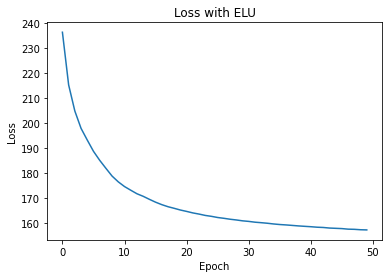

In [ ]:
plt.title("Loss with ELU")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_log)
#plt.legend(["BINARY","TOZERO"], loc='upper left')
plt.show()

In [ ]:
l1 = [236.417,215.391,204.929,197.997,193.331,188.832,185.239,182.039,178.917,176.607,174.741,173.280,171.864,170.849,
        169.639,168.496,167.510,166.687,166.043,165.359,164.809,164.206,163.743,163.203,162.836,162.372,162.053,161.682,
        161.392,161.045]

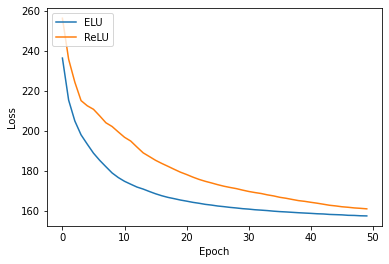

In [ ]:
#plt.title("Loss with ELU")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_log)
plt.plot(linear_loss_log)
plt.legend(["ELU","ReLU"], loc='upper left')
plt.show()

In [ ]:
#35m7s
linear_loss_log = []
for epoch in range(50):
    epoch_loss = 0.0
    # anneal KLD from 0 to 1 over 100 epochs
    #kld_weight = min(epoch / 99.0, 1.0)
    for x, _ in train_loader:
        x = x.to(device)

        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        z = torch.zeros(batch_size, nz).to(device).requires_grad_()
        g, mu, logvar = L(z)
        inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
        z = (-grad)

        # now with z as our new latent points, optimise the data fitting loss
        g, mu, logvar = L(z)
        outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        optim_l.zero_grad()
        outer_loss.backward()
        optim_l.step()

        epoch_loss += outer_loss.item()
    
    linear_loss_log.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch}  Loss: {epoch_loss/len(train_loader):.3f}")


Epoch: 0  Loss: 256.360
Epoch: 1  Loss: 235.844
Epoch: 2  Loss: 224.358
Epoch: 3  Loss: 215.133
Epoch: 4  Loss: 212.549
Epoch: 5  Loss: 210.784
Epoch: 6  Loss: 207.500
Epoch: 7  Loss: 204.042
Epoch: 8  Loss: 202.162
Epoch: 9  Loss: 199.425
Epoch: 10  Loss: 196.772
Epoch: 11  Loss: 194.875
Epoch: 12  Loss: 191.885
Epoch: 13  Loss: 188.990
Epoch: 14  Loss: 187.127
Epoch: 15  Loss: 185.241
Epoch: 16  Loss: 183.678
Epoch: 17  Loss: 182.228
Epoch: 18  Loss: 180.742
Epoch: 19  Loss: 179.307
Epoch: 20  Loss: 178.124
Epoch: 21  Loss: 176.837
Epoch: 22  Loss: 175.687
Epoch: 23  Loss: 174.734
Epoch: 24  Loss: 173.917
Epoch: 25  Loss: 173.050
Epoch: 26  Loss: 172.281
Epoch: 27  Loss: 171.648
Epoch: 28  Loss: 171.077
Epoch: 29  Loss: 170.333
Epoch: 30  Loss: 169.652
Epoch: 31  Loss: 169.101
Epoch: 32  Loss: 168.627
Epoch: 33  Loss: 167.955
Epoch: 34  Loss: 167.425
Epoch: 35  Loss: 166.727
Epoch: 36  Loss: 166.249
Epoch: 37  Loss: 165.654
Epoch: 38  Loss: 165.077
Epoch: 39  Loss: 164.709
Epoch: 40 

## autoencoder

In [ ]:
'''
nc = 1
nz = 48
ngf = 32
'''
class AE(nn.Module):
    def __init__(self):
        print("running init")
        super(AE, self).__init__()
        self.fc21 = nn.Linear(nz, nz)
        self.fc22 = nn.Linear(nz, nz)
        
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf,4, 1, 0,bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf),
            nn.ConvTranspose2d(ngf, ngf * 2, 4,2, 1, bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf * 2),
            nn.ConvTranspose2d(ngf * 2, ngf * 4, 4,1, 1, bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf * 4),
            nn.ConvTranspose2d(ngf * 4, nz, 4,1, 2, bias=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 1, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 1, 2, bias=True),
            nn.Sigmoid()
        )

        
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, input):
        mu = self.fc21(input)
        logvar = self.fc22(input)
        z = self.reparameterize(mu, logvar)
        #print("z")
        #print(z.unsqueeze(-1).unsqueeze(-1).shape)
        encoded = self.encoder(z.unsqueeze(-1).unsqueeze(-1))
        #print("encode")
        #print(encoded.shape)
        decoded = self.decoder(encoded)
        #print("decode")
        #print(decoded.shape)
        #print("running forward")
        return decoded, mu, logvar
    
    def sample(self, batch_size):
        z = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(z)


In [ ]:
A = AE().to(device)

optim_a = torch.optim.Adam(lr=lr, params=A.parameters())

running init


In [ ]:
loss_log_a = []
for epoch in range(50):
    epoch_loss = 0.0
    # anneal KLD from 0 to 1 over 100 epochs
    #kld_weight = min(epoch / 99.0, 1.0)
    for x, _ in train_loader:
        x = x.to(device)
        
        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        z = torch.zeros(batch_size, nz).to(device).requires_grad_()
        g, mu, logvar = A(z)
        #print(g.shape)
        inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
        z = (-grad)

        # now with z as our new latent points, optimise the data fitting loss
        g, mu, logvar = A(z)
        outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        optim_a.zero_grad()
        outer_loss.backward()
        optim_a.step()

        epoch_loss += outer_loss.item()
    
    loss_log_a.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch}  Loss: {epoch_loss/len(train_loader):.3f}")

Epoch: 0  Loss: 287.618
Epoch: 1  Loss: 223.163
Epoch: 2  Loss: 211.085
Epoch: 3  Loss: 203.892
Epoch: 4  Loss: 196.219
Epoch: 5  Loss: 188.945
Epoch: 6  Loss: 182.940
Epoch: 7  Loss: 179.080
Epoch: 8  Loss: 175.796
Epoch: 9  Loss: 173.149
Epoch: 10  Loss: 170.970
Epoch: 11  Loss: 169.354
Epoch: 12  Loss: 167.902
Epoch: 13  Loss: 166.862
Epoch: 14  Loss: 165.722
Epoch: 15  Loss: 164.816
Epoch: 16  Loss: 164.131
Epoch: 17  Loss: 163.404
Epoch: 18  Loss: 162.874
Epoch: 19  Loss: 162.253
Epoch: 20  Loss: 161.812
Epoch: 21  Loss: 161.278
Epoch: 22  Loss: 160.798
Epoch: 23  Loss: 160.498
Epoch: 24  Loss: 160.095
Epoch: 25  Loss: 159.722
Epoch: 26  Loss: 159.385
Epoch: 27  Loss: 159.044
Epoch: 28  Loss: 158.773
Epoch: 29  Loss: 158.516


KeyboardInterrupt: ignored

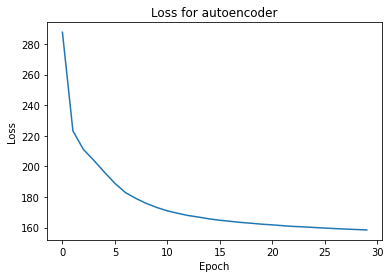

In [ ]:
plt.title("Loss for autoencoder")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_log_a)
#plt.legend(["BINARY","TOZERO"], loc='upper left')
plt.show()

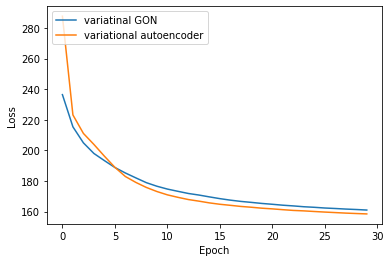

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(l1)
plt.plot(l2)
plt.legend(["variatinal GON","variational autoencoder"], loc='upper left')
plt.show()

In [ ]:
'''
nc = 1
nz = 48
ngf = 32
'''
class AE2(nn.Module):
    def __init__(self):
        print("running init")
        super(AE2, self).__init__()
        self.fc21 = nn.Linear(nz, nz)
        self.fc22 = nn.Linear(nz, nz)
        
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf,4, 2, 1,bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf),
            nn.ConvTranspose2d(ngf, ngf * 2, 4,2, 1, bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf * 2),
            nn.ConvTranspose2d(ngf * 2, ngf * 4, 4,1, 1, bias=True),
            nn.ELU(),
            nn.BatchNorm2d(ngf * 4),
            nn.ConvTranspose2d(ngf * 4, nz, 4,1, 2, bias=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

        
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, input):
        #print("z")
        #print(z.unsqueeze(-1).unsqueeze(-1).shape)
        encoded = self.encoder(input.unsqueeze(-1).unsqueeze(-1))
        #print(encoded.shape)
        mu = encoded[:, 0, :]
        logvar = encoded[:, 1, :]
        z = self.reparameterize(mu, logvar)
        z = z.unsqueeze(1)
        #print(z.shape)
        #print("encode")
        #print(encoded.shape)
        decoded = self.decoder(z)
        #print(decoded.shape)
        #print("decode")
        #print(decoded.shape)
        #print("running forward")
        return decoded, mu, logvar
    
    def sample(self, batch_size):
        z = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(z)


In [ ]:
A2 = AE2().to(device)

optim_a2 = torch.optim.Adam(lr=lr, params=A2.parameters())

running init


In [ ]:
#35m
loss_log_b = []
for epoch in range(50):
    epoch_loss = 0.0
    # anneal KLD from 0 to 1 over 100 epochs
    #kld_weight = min(epoch / 99.0, 1.0)
    for x, _ in train_loader:
        x = x.to(device)
        
        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        z = torch.zeros(batch_size, nz).to(device).requires_grad_()
        g, mu, logvar = A2(z)
        #print(g.shape)
        inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
        z = (-grad)

        # now with z as our new latent points, optimise the data fitting loss
        g, mu, logvar = A2(z)
        outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        optim_a2.zero_grad()
        outer_loss.backward()
        optim_a2.step()

        epoch_loss += outer_loss.item()
    
    loss_log_b.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch}  Loss: {epoch_loss/len(train_loader):.3f}")


Epoch: 0  Loss: 303.314
Epoch: 1  Loss: 173.918
Epoch: 2  Loss: 157.681
Epoch: 3  Loss: 151.959
Epoch: 4  Loss: 148.985
Epoch: 5  Loss: 146.732
Epoch: 6  Loss: 145.216
Epoch: 7  Loss: 144.108
Epoch: 8  Loss: 143.058
Epoch: 9  Loss: 142.342
Epoch: 10  Loss: 141.558
Epoch: 11  Loss: 140.889
Epoch: 12  Loss: 140.324
Epoch: 13  Loss: 139.894
Epoch: 14  Loss: 139.435
Epoch: 15  Loss: 138.991
Epoch: 16  Loss: 138.616
Epoch: 17  Loss: 138.285
Epoch: 18  Loss: 137.941
Epoch: 19  Loss: 137.623
Epoch: 20  Loss: 137.312
Epoch: 21  Loss: 137.002
Epoch: 22  Loss: 136.836
Epoch: 23  Loss: 136.556
Epoch: 24  Loss: 136.273
Epoch: 25  Loss: 136.132
Epoch: 26  Loss: 135.861
Epoch: 27  Loss: 135.724
Epoch: 28  Loss: 135.540
Epoch: 29  Loss: 135.264


KeyboardInterrupt: ignored

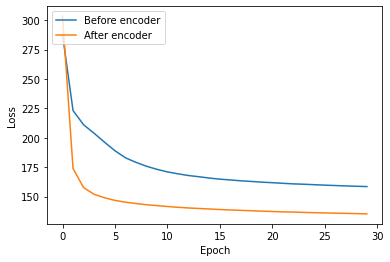

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_log_a)
plt.plot(loss_log_b)
plt.legend(["Before encoder","After encoder"], loc='upper left')
plt.show()

## Implicit

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'fashion' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
num_latent = 32
hidden_features = 256
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create the GON network (a SIREN as in https://vsitzmann.github.io/siren/)
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()
    
    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)
        
def gon_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

# helper functions
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z, coords):
    lz = z.data.clone().squeeze(1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    z_slerp_rep = z_slerp.unsqueeze(1).repeat(1,coords.size(1),1) 
    g_slerp = model(torch.cat((coords, z_slerp_rep), dim=-1))
    return g_slerp

def gon_sample(model, recent_zs, coords):
    zs = torch.cat(recent_zs, dim=0).squeeze(1).cpu().numpy()
    mean = np.mean(zs, axis=0)
    cov = np.cov(zs.T)
    sample = np.random.multivariate_normal(mean, cov, size=batch_size)
    sample = torch.tensor(sample).unsqueeze(1).repeat(1,coords.size(1),1).to(device).float()
    model_input = torch.cat((coords, sample), dim=-1)
    return model(model_input)


In [ ]:
dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
I = gon_model(gon_shape).to(device)

optim_i = torch.optim.Adam(lr=lr, params=I.parameters())
c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(I.parameters()))}')

> Number of parameters 206593


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
implicit_loss_log = []
mnist_loss_implicit = []
for step in range(50):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1).reshape(batch_size, -1, n_channels)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    # now with z as our new latent points, optimise the data fitting loss
    z_rep = z.repeat(1, c.size(1), 1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim_i.zero_grad()
    L_outer.backward()
    optim_i.step()

    # compute sampling statistics
    implicit_loss_log.append(z.detach())
    implicit_loss_log = implicit_loss_log[-100:]

    #if step % 100 == 0 and step > 0:
    mnist_loss_implicit.append(L_outer.item())
    print(f"Step: {step}   Loss: {L_outer.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/recon_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot interpolations
    torchvision.utils.save_image(torch.clamp(slerp_batch(I, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/slerp_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot samples
    torchvision.utils.save_image(torch.clamp(gon_sample(I, implicit_loss_log, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/sample_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)

Step: 0   Loss: 29.497
Step: 1   Loss: 30.084
Step: 2   Loss: 25.935
Step: 3   Loss: 29.541
Step: 4   Loss: 29.703
Step: 5   Loss: 26.994
Step: 6   Loss: 28.358
Step: 7   Loss: 27.674
Step: 8   Loss: 26.250
Step: 9   Loss: 27.822
Step: 10   Loss: 26.787
Step: 11   Loss: 26.776
Step: 12   Loss: 28.750
Step: 13   Loss: 28.340
Step: 14   Loss: 30.202
Step: 15   Loss: 26.897
Step: 16   Loss: 26.261
Step: 17   Loss: 24.148
Step: 18   Loss: 25.364
Step: 19   Loss: 27.876
Step: 20   Loss: 25.921
Step: 21   Loss: 27.341
Step: 22   Loss: 25.842
Step: 23   Loss: 25.196
Step: 24   Loss: 26.171
Step: 25   Loss: 24.661
Step: 26   Loss: 27.103
Step: 27   Loss: 23.954
Step: 28   Loss: 23.947
Step: 29   Loss: 25.831
Step: 30   Loss: 24.572
Step: 31   Loss: 23.958
Step: 32   Loss: 25.870
Step: 33   Loss: 24.367
Step: 34   Loss: 24.725
Step: 35   Loss: 25.488
Step: 36   Loss: 23.222
Step: 37   Loss: 23.229
Step: 38   Loss: 26.204
Step: 39   Loss: 24.082
Step: 40   Loss: 25.097
Step: 41   Loss: 22.476
St

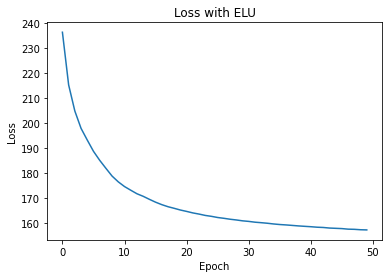

In [ ]:
plt.title("Loss with implicit GON")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_log)
#plt.legend(["BINARY","TOZERO"], loc='upper left')
plt.show()

## GON

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'mnist' # choices - ['mnist', 'fashion']
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 64
nz = 32
ngf = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

G = Generator().to(device)

optim_g = torch.optim.Adam(lr=lr, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')

mnist_loss_gon = []
for step in range(50):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    g = G(z)
    inner_loss = ((g - x)**2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = G(z)
    outer_loss = ((g - x)**2).sum(1).mean()
    optim_g.zero_grad()
    outer_loss.backward()
    optim_g.step()

    mnist_loss_gon.append(outer_loss.item())
    #if step % 100 == 0 and step > 0:    
    print(f"Step: {step}  Loss: {outer_loss.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1), f'imgs/recon_{step}.png', 
          nrow=int(np.sqrt(batch_size)), padding=0)

> Number of parameters 74321
Step: 0  Loss: 0.213
Step: 1  Loss: 0.215
Step: 2  Loss: 0.209
Step: 3  Loss: 0.208
Step: 4  Loss: 0.204
Step: 5  Loss: 0.200
Step: 6  Loss: 0.197
Step: 7  Loss: 0.194
Step: 8  Loss: 0.190
Step: 9  Loss: 0.187
Step: 10  Loss: 0.186
Step: 11  Loss: 0.184
Step: 12  Loss: 0.181
Step: 13  Loss: 0.177
Step: 14  Loss: 0.175
Step: 15  Loss: 0.174
Step: 16  Loss: 0.173
Step: 17  Loss: 0.170
Step: 18  Loss: 0.169
Step: 19  Loss: 0.164
Step: 20  Loss: 0.164
Step: 21  Loss: 0.163
Step: 22  Loss: 0.163
Step: 23  Loss: 0.159
Step: 24  Loss: 0.158
Step: 25  Loss: 0.156
Step: 26  Loss: 0.154
Step: 27  Loss: 0.153
Step: 28  Loss: 0.153
Step: 29  Loss: 0.152
Step: 30  Loss: 0.153
Step: 31  Loss: 0.153
Step: 32  Loss: 0.149
Step: 33  Loss: 0.147
Step: 34  Loss: 0.143
Step: 35  Loss: 0.145
Step: 36  Loss: 0.146
Step: 37  Loss: 0.141
Step: 38  Loss: 0.142
Step: 39  Loss: 0.144
Step: 40  Loss: 0.141
Step: 41  Loss: 0.141
Step: 42  Loss: 0.143
Step: 43  Loss: 0.142
Step: 44  Los

# FashionMNist

## Variational GON

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 64
nz = 48
ngf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc21 = nn.Linear(nz, nz)
        self.fc22 = nn.Linear(nz, nz)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, input):
        mu = self.fc21(input)
        logvar = self.fc22(input)
        z = self.reparameterize(mu, logvar)
        result = self.main(z.unsqueeze(-1).unsqueeze(-1))
        return result, mu, logvar
    
    def sample(self, batch_size):
        z = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(z)


In [ ]:
dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
#train_iterator = iter(cycle(train_loader))

F = Generator().to(device)

optim = torch.optim.Adam(lr=lr, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')

> Number of parameters 268033


In [ ]:
#35m49s
loss_log = []
for epoch in range(50):
    epoch_loss = 0.0
    # anneal KLD from 0 to 1 over 100 epochs
    #kld_weight = min(epoch / 99.0, 1.0)
    for x, _ in train_loader:
        x = x.to(device)

        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        z = torch.zeros(batch_size, nz).to(device).requires_grad_()
        g, mu, logvar = F(z)
        inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
        z = (-grad)

        # now with z as our new latent points, optimise the data fitting loss
        g, mu, logvar = F(z)
        outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)
        optim.zero_grad()
        outer_loss.backward()
        optim.step()

        epoch_loss += outer_loss.item()
    
    loss_log.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch}  Loss: {epoch_loss/len(train_loader):.3f}")

    # plot reconstructions
    torchvision.utils.save_image(g, f'imgs/recon_{epoch}.png', 
        nrow=int(np.sqrt(batch_size)), padding=0)
    
    # plot samples
    torchvision.utils.save_image(F.sample(batch_size), f'imgs/sample_{epoch}.png', 
        nrow=int(np.sqrt(batch_size)), padding=0)
  

Epoch: 0  Loss: 895.801
Epoch: 1  Loss: 895.848
Epoch: 2  Loss: 895.874
Epoch: 3  Loss: 895.948
Epoch: 4  Loss: 895.853
Epoch: 5  Loss: 895.761
Epoch: 6  Loss: 895.956
Epoch: 7  Loss: 895.860
Epoch: 8  Loss: 895.882
Epoch: 9  Loss: 895.934
Epoch: 10  Loss: 895.822
Epoch: 11  Loss: 895.799
Epoch: 12  Loss: 895.811
Epoch: 13  Loss: 895.881
Epoch: 14  Loss: 895.879
Epoch: 15  Loss: 895.851
Epoch: 16  Loss: 895.901
Epoch: 17  Loss: 895.903
Epoch: 18  Loss: 895.904
Epoch: 19  Loss: 895.895
Epoch: 20  Loss: 895.883
Epoch: 21  Loss: 895.847
Epoch: 22  Loss: 895.896
Epoch: 23  Loss: 895.960
Epoch: 24  Loss: 895.861
Epoch: 25  Loss: 895.906
Epoch: 26  Loss: 895.920
Epoch: 27  Loss: 895.827
Epoch: 28  Loss: 895.988
Epoch: 29  Loss: 895.912


KeyboardInterrupt: ignored

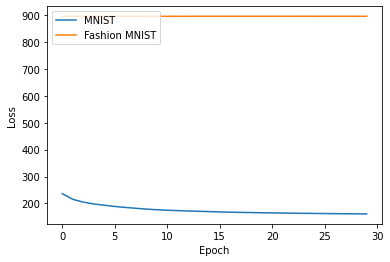

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(l1)
plt.plot(loss_log)
plt.legend(["MNIST","Fashion MNIST"], loc='upper left')
plt.show()

##GON

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'mnist' # choices - ['mnist', 'fashion']
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 64
nz = 32
ngf = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

G = Generator().to(device)

optim_g = torch.optim.Adam(lr=lr, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
fashion_loss_gon = []
for step in range(300):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    g = G(z)
    inner_loss = ((g - x)**2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = G(z)
    outer_loss = ((g - x)**2).sum(1).mean()
    optim_g.zero_grad()
    outer_loss.backward()
    optim_g.step()

    #if step % 100 == 0 and step > 0:  
    fashion_loss_gon.append(outer_loss.item())  
    print(f"Step: {step}  Loss: {outer_loss.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1), f'imgs/recon_{step}.png', 
          nrow=int(np.sqrt(batch_size)), padding=0)

> Number of parameters 74321
Step: 0  Loss: 0.190
Step: 1  Loss: 0.201
Step: 2  Loss: 0.179
Step: 3  Loss: 0.184
Step: 4  Loss: 0.181
Step: 5  Loss: 0.166
Step: 6  Loss: 0.176
Step: 7  Loss: 0.171
Step: 8  Loss: 0.162
Step: 9  Loss: 0.165
Step: 10  Loss: 0.159
Step: 11  Loss: 0.161
Step: 12  Loss: 0.160
Step: 13  Loss: 0.150
Step: 14  Loss: 0.145
Step: 15  Loss: 0.151
Step: 16  Loss: 0.142
Step: 17  Loss: 0.139
Step: 18  Loss: 0.136
Step: 19  Loss: 0.130
Step: 20  Loss: 0.141
Step: 21  Loss: 0.129
Step: 22  Loss: 0.129
Step: 23  Loss: 0.135
Step: 24  Loss: 0.117
Step: 25  Loss: 0.134
Step: 26  Loss: 0.122
Step: 27  Loss: 0.114
Step: 28  Loss: 0.114
Step: 29  Loss: 0.116
Step: 30  Loss: 0.116
Step: 31  Loss: 0.117
Step: 32  Loss: 0.111
Step: 33  Loss: 0.114
Step: 34  Loss: 0.111
Step: 35  Loss: 0.111
Step: 36  Loss: 0.099
Step: 37  Loss: 0.110
Step: 38  Loss: 0.112
Step: 39  Loss: 0.098
Step: 40  Loss: 0.098
Step: 41  Loss: 0.096
Step: 42  Loss: 0.098
Step: 43  Loss: 0.098
Step: 44  Los

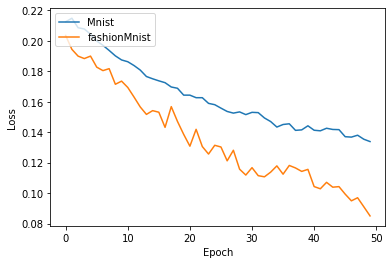

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(mnist_loss_gon)
plt.plot(fashion_loss_gon)
plt.legend(["Mnist","fashionMnist"], loc='upper left')
plt.show()

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'mnist' # choices - ['mnist', 'fashion']
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 32
nz = 32
ngf = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

G = Generator().to(device)

optim_g = torch.optim.Adam(lr=lr, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
fashion_loss_gon_32 = []
for step in range(300):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    g = G(z)
    inner_loss = ((g - x)**2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = G(z)
    outer_loss = ((g - x)**2).sum(1).mean()
    optim_g.zero_grad()
    outer_loss.backward()
    optim_g.step()

    #if step % 100 == 0 and step > 0:  
    fashion_loss_gon_32.append(outer_loss.item())  
    print(f"Step: {step}  Loss: {outer_loss.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1), f'imgs/recon_{step}.png', 
          nrow=int(np.sqrt(batch_size)), padding=0)

> Number of parameters 74321
Step: 0  Loss: 0.198
Step: 1  Loss: 0.202
Step: 2  Loss: 0.190
Step: 3  Loss: 0.185
Step: 4  Loss: 0.174
Step: 5  Loss: 0.175
Step: 6  Loss: 0.181
Step: 7  Loss: 0.161
Step: 8  Loss: 0.171
Step: 9  Loss: 0.169
Step: 10  Loss: 0.155
Step: 11  Loss: 0.153
Step: 12  Loss: 0.159
Step: 13  Loss: 0.156
Step: 14  Loss: 0.150
Step: 15  Loss: 0.151
Step: 16  Loss: 0.147
Step: 17  Loss: 0.143
Step: 18  Loss: 0.141
Step: 19  Loss: 0.143
Step: 20  Loss: 0.137
Step: 21  Loss: 0.140
Step: 22  Loss: 0.131
Step: 23  Loss: 0.135
Step: 24  Loss: 0.126
Step: 25  Loss: 0.131
Step: 26  Loss: 0.129
Step: 27  Loss: 0.122
Step: 28  Loss: 0.123
Step: 29  Loss: 0.116
Step: 30  Loss: 0.130
Step: 31  Loss: 0.124
Step: 32  Loss: 0.121
Step: 33  Loss: 0.116
Step: 34  Loss: 0.100
Step: 35  Loss: 0.117
Step: 36  Loss: 0.122
Step: 37  Loss: 0.123
Step: 38  Loss: 0.106
Step: 39  Loss: 0.106
Step: 40  Loss: 0.120
Step: 41  Loss: 0.103
Step: 42  Loss: 0.111
Step: 43  Loss: 0.105
Step: 44  Los

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'mnist' # choices - ['mnist', 'fashion']
img_size = 32
nc = 1

# training info
lr = 1e-4
batch_size = 128
nz = 32
ngf = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

G = Generator().to(device)

optim_g = torch.optim.Adam(lr=lr, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
fashion_loss_gon_128 = []
for step in range(300):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    g = G(z)
    inner_loss = ((g - x)**2).sum(1).mean()
    grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = G(z)
    outer_loss = ((g - x)**2).sum(1).mean()
    optim_g.zero_grad()
    outer_loss.backward()
    optim_g.step()

    #if step % 100 == 0 and step > 0:  
    fashion_loss_gon_128.append(outer_loss.item())  
    print(f"Step: {step}  Loss: {outer_loss.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1), f'imgs/recon_{step}.png', 
          nrow=int(np.sqrt(batch_size)), padding=0)

> Number of parameters 74321
Step: 0  Loss: 0.190
Step: 1  Loss: 0.192
Step: 2  Loss: 0.177
Step: 3  Loss: 0.189
Step: 4  Loss: 0.182
Step: 5  Loss: 0.186
Step: 6  Loss: 0.177
Step: 7  Loss: 0.168
Step: 8  Loss: 0.169
Step: 9  Loss: 0.167
Step: 10  Loss: 0.167
Step: 11  Loss: 0.157
Step: 12  Loss: 0.161
Step: 13  Loss: 0.149
Step: 14  Loss: 0.154
Step: 15  Loss: 0.151
Step: 16  Loss: 0.145
Step: 17  Loss: 0.149
Step: 18  Loss: 0.147
Step: 19  Loss: 0.138
Step: 20  Loss: 0.134
Step: 21  Loss: 0.134
Step: 22  Loss: 0.137
Step: 23  Loss: 0.136
Step: 24  Loss: 0.128
Step: 25  Loss: 0.128
Step: 26  Loss: 0.122
Step: 27  Loss: 0.128
Step: 28  Loss: 0.125
Step: 29  Loss: 0.130
Step: 30  Loss: 0.114
Step: 31  Loss: 0.125
Step: 32  Loss: 0.121
Step: 33  Loss: 0.119
Step: 34  Loss: 0.112
Step: 35  Loss: 0.109
Step: 36  Loss: 0.114
Step: 37  Loss: 0.113
Step: 38  Loss: 0.105
Step: 39  Loss: 0.106
Step: 40  Loss: 0.110
Step: 41  Loss: 0.112
Step: 42  Loss: 0.105
Step: 43  Loss: 0.100
Step: 44  Los

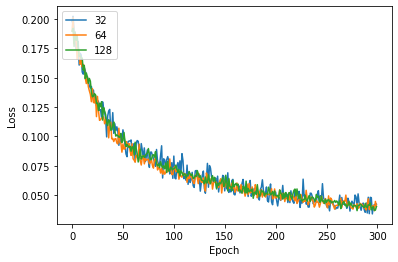

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(fashion_loss_gon_32)
plt.plot(fashion_loss_gon)
plt.plot(fashion_loss_gon_128)
plt.legend(["32","64","128"], loc='upper left')
plt.show()

##Implicit



In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'fashion' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
num_latent = 32
hidden_features = 256
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

#F = Generator().to(device)
#L = LinearGenerator().to(device)
gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
I = gon_model(gon_shape).to(device)

#optim = torch.optim.Adam(lr=lr, params=F.parameters())
#optim_l = torch.optim.Adam(lr=lr, params=L.parameters())
optim_i = torch.optim.Adam(lr=lr, params=I.parameters())
c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(I.parameters()))}')



> Number of parameters 206593


In [ ]:
fashion_loss_log = []
fashion_loss_implicit = []
for step in range(50):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1).reshape(batch_size, -1, n_channels)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    # now with z as our new latent points, optimise the data fitting loss
    z_rep = z.repeat(1, c.size(1), 1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim_i.zero_grad()
    L_outer.backward()
    optim_i.step()

    # compute sampling statistics
    fashion_loss_log.append(z.detach())
    fashion_loss_log = fashion_loss_log[-100:]

    #if step % 100 == 0 and step > 0:
    fashion_loss_implicit.append(L_outer.item())
    print(f"Step: {step}   Loss: {L_outer.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/recon_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot interpolations
    torchvision.utils.save_image(torch.clamp(slerp_batch(I, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/slerp_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot samples
    torchvision.utils.save_image(torch.clamp(gon_sample(I, implicit_loss_log, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/sample_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)

Step: 0   Loss: 23.980
Step: 1   Loss: 23.297
Step: 2   Loss: 22.252
Step: 3   Loss: 22.996
Step: 4   Loss: 21.963
Step: 5   Loss: 20.889
Step: 6   Loss: 23.653
Step: 7   Loss: 20.959
Step: 8   Loss: 21.156
Step: 9   Loss: 25.702
Step: 10   Loss: 20.783
Step: 11   Loss: 22.411
Step: 12   Loss: 22.582
Step: 13   Loss: 21.516
Step: 14   Loss: 20.620
Step: 15   Loss: 23.103
Step: 16   Loss: 21.079
Step: 17   Loss: 22.469
Step: 18   Loss: 20.969
Step: 19   Loss: 22.766
Step: 20   Loss: 21.479
Step: 21   Loss: 23.733
Step: 22   Loss: 22.017
Step: 23   Loss: 21.320
Step: 24   Loss: 19.792
Step: 25   Loss: 21.122
Step: 26   Loss: 22.362
Step: 27   Loss: 21.082
Step: 28   Loss: 23.406
Step: 29   Loss: 20.856
Step: 30   Loss: 21.174
Step: 31   Loss: 19.913
Step: 32   Loss: 21.384
Step: 33   Loss: 20.292
Step: 34   Loss: 19.459
Step: 35   Loss: 19.679
Step: 36   Loss: 22.226
Step: 37   Loss: 20.782
Step: 38   Loss: 20.483
Step: 39   Loss: 22.186
Step: 40   Loss: 20.895
Step: 41   Loss: 20.504
St

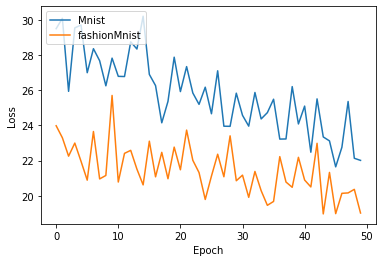

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(mnist_loss_implicit)
plt.plot(fashion_loss_implicit)
plt.legend(["Mnist","fashionMnist"], loc='upper left')
plt.show()

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'fashion' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
num_latent = 64
hidden_features = 256
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

#F = Generator().to(device)
#L = LinearGenerator().to(device)
gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
I = gon_model(gon_shape).to(device)

#optim = torch.optim.Adam(lr=lr, params=F.parameters())
#optim_l = torch.optim.Adam(lr=lr, params=L.parameters())
optim_i = torch.optim.Adam(lr=lr, params=I.parameters())
c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(I.parameters()))}')



> Number of parameters 214785


In [ ]:
fashion_loss_log = []
fashion_loss_implicit_64 = []
for step in range(50):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1).reshape(batch_size, -1, n_channels)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    # now with z as our new latent points, optimise the data fitting loss
    z_rep = z.repeat(1, c.size(1), 1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim_i.zero_grad()
    L_outer.backward()
    optim_i.step()

    # compute sampling statistics
    fashion_loss_log.append(z.detach())
    fashion_loss_log = fashion_loss_log[-100:]

    #if step % 100 == 0 and step > 0:
    fashion_loss_implicit_64.append(L_outer.item())
    print(f"Step: {step}   Loss: {L_outer.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/recon_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot interpolations
    torchvision.utils.save_image(torch.clamp(slerp_batch(I, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/slerp_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    

Step: 0   Loss: 34.461
Step: 1   Loss: 31.469
Step: 2   Loss: 30.509
Step: 3   Loss: 33.104
Step: 4   Loss: 32.095
Step: 5   Loss: 29.655
Step: 6   Loss: 34.094
Step: 7   Loss: 28.024
Step: 8   Loss: 30.661
Step: 9   Loss: 30.620
Step: 10   Loss: 27.710
Step: 11   Loss: 33.349
Step: 12   Loss: 29.233
Step: 13   Loss: 29.064
Step: 14   Loss: 29.643
Step: 15   Loss: 33.061
Step: 16   Loss: 29.944
Step: 17   Loss: 26.702
Step: 18   Loss: 29.728
Step: 19   Loss: 28.850
Step: 20   Loss: 27.318
Step: 21   Loss: 26.462
Step: 22   Loss: 29.919
Step: 23   Loss: 28.084
Step: 24   Loss: 29.240
Step: 25   Loss: 27.308
Step: 26   Loss: 29.961
Step: 27   Loss: 27.090
Step: 28   Loss: 26.795
Step: 29   Loss: 25.268
Step: 30   Loss: 28.916
Step: 31   Loss: 25.884
Step: 32   Loss: 25.881
Step: 33   Loss: 28.100
Step: 34   Loss: 28.325
Step: 35   Loss: 25.799
Step: 36   Loss: 25.527
Step: 37   Loss: 24.821
Step: 38   Loss: 24.976
Step: 39   Loss: 27.729
Step: 40   Loss: 23.927
Step: 41   Loss: 25.679
St

In [ ]:
plot_dir = 'imgs'
os.makedirs(plot_dir, exist_ok=True)

# image data
dataset_name = 'fashion' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
num_latent = 128
hidden_features = 256
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size), torchvision.transforms.ToTensor()
]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

#F = Generator().to(device)
#L = LinearGenerator().to(device)
gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
I = gon_model(gon_shape).to(device)

#optim = torch.optim.Adam(lr=lr, params=F.parameters())
#optim_l = torch.optim.Adam(lr=lr, params=L.parameters())
optim_i = torch.optim.Adam(lr=lr, params=I.parameters())
c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(I.parameters()))}')



> Number of parameters 231169


In [ ]:
fashion_loss_log = []
fashion_loss_implicit_128 = []
for step in range(50):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1).reshape(batch_size, -1, n_channels)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    # now with z as our new latent points, optimise the data fitting loss
    z_rep = z.repeat(1, c.size(1), 1)
    g = I(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim_i.zero_grad()
    L_outer.backward()
    optim_i.step()

    # compute sampling statistics
    fashion_loss_log.append(z.detach())
    fashion_loss_log = fashion_loss_log[-100:]

    #if step % 100 == 0 and step > 0:
    fashion_loss_implicit_128.append(L_outer.item())
    print(f"Step: {step}   Loss: {L_outer.item():.3f}")

    # plot reconstructions
    torchvision.utils.save_image(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/recon_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    # plot interpolations
    torchvision.utils.save_image(torch.clamp(slerp_batch(I, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), 
        f'imgs/slerp_{step}.png', nrow=int(np.sqrt(batch_size)), padding=0)
        
    

Step: 0   Loss: 168.775
Step: 1   Loss: 99.673
Step: 2   Loss: 91.626
Step: 3   Loss: 102.010
Step: 4   Loss: 83.662
Step: 5   Loss: 78.239
Step: 6   Loss: 95.523
Step: 7   Loss: 85.849
Step: 8   Loss: 86.245
Step: 9   Loss: 85.155
Step: 10   Loss: 81.818
Step: 11   Loss: 78.497
Step: 12   Loss: 81.081
Step: 13   Loss: 88.453
Step: 14   Loss: 77.722
Step: 15   Loss: 75.320
Step: 16   Loss: 78.961
Step: 17   Loss: 78.769
Step: 18   Loss: 75.977
Step: 19   Loss: 67.433
Step: 20   Loss: 72.657
Step: 21   Loss: 76.514
Step: 22   Loss: 76.987
Step: 23   Loss: 70.689
Step: 24   Loss: 68.192
Step: 25   Loss: 61.174
Step: 26   Loss: 66.942
Step: 27   Loss: 66.274
Step: 28   Loss: 57.636
Step: 29   Loss: 56.255
Step: 30   Loss: 55.956
Step: 31   Loss: 54.803
Step: 32   Loss: 57.958
Step: 33   Loss: 57.495
Step: 34   Loss: 56.372
Step: 35   Loss: 53.574
Step: 36   Loss: 55.581
Step: 37   Loss: 52.735
Step: 38   Loss: 50.967
Step: 39   Loss: 52.064
Step: 40   Loss: 46.069
Step: 41   Loss: 47.605


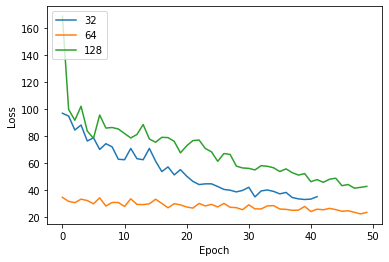

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(fashion_loss_implicit)
plt.plot(fashion_loss_implicit_64)
plt.plot(fashion_loss_implicit_128)
plt.legend(["32","64","128"], loc='upper left')
plt.show()